In [1]:
library(Seurat)
library(Signac)
library(tidyverse)
library(ggpubr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::reduce() masks Signac::reduce()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
charmmesc = readRDS("/zliu_ssd/CHARM/CHARM_mesc/1_preprocess/charm.rds")
charmbrain = readRDS("/zliu_ssd/CHARM/CHARM_brain/1_createobj_embedding/charm.rds")

In [3]:
structure_pass_mesc = subset(charmmesc,subset=`5k` < 2)
cellnames_keep_brain = charmbrain[[]] %>% filter(`5k` < 2) %>% filter(!celltype %in% c("Inh_Unknown1","Inh_Unknown2","Ex_Unknown1","Ex_Unknown2")) %>% pull(cellname)
structure_pass_brain = subset(charmbrain,subset=cellname %in% cellnames_keep_brain)

metadata = rbind(
    structure_pass_mesc[[]] %>% select(cellname) %>% mutate(celltype = "mESC"),
    structure_pass_brain[[]] %>% select(cellname,celltype)
)

structure_pass_mesc[["rna"]]$counts %>% as.matrix() %>% as.data.frame() %>% rownames_to_column("gene") -> mesc_rna_mat
structure_pass_brain[["RNA"]]$counts %>% as.matrix() %>% as.data.frame() %>% rownames_to_column("gene") -> brain_rna_mat
rnamat = brain_rna_mat %>% full_join(mesc_rna_mat)
rnamat[is.na(rnamat)] <- 0

Joining with `by = join_by(gene)`


In [4]:
# binarise_rnamat <- (rnamat %>% column_to_rownames("gene")) >= 1
# binarise_rnamat <- binarise_rnamat %>% rowSums() / ncol(binarise_rnamat) %>% sort(decreasing = TRUE) 
# zeroratio_rnamat = binarise_rnamat %>% as.data.frame() %>% rownames_to_column("gene") 
# names(zeroratio_rnamat) <- c("gene","nonzeroratio")
# zeroratio_rnamat %>% filter(nonzeroratio > 0.05) %>% pull(gene) -> genes_considered 

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Joining with `by = join_by(cellname)`


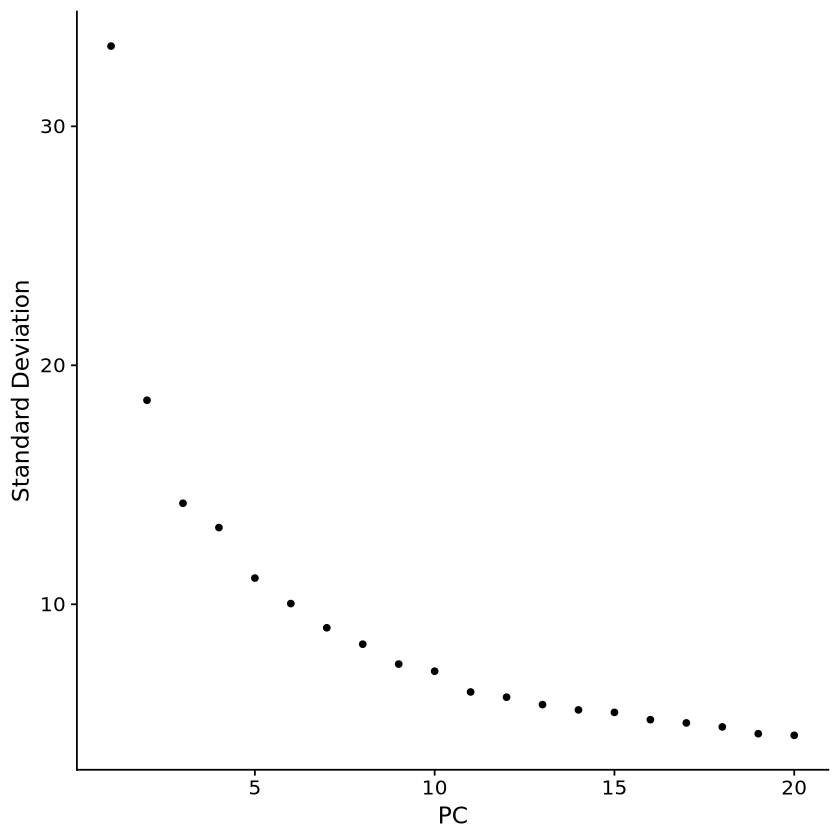

In [5]:
rnamat %>% column_to_rownames("gene") %>% as.matrix() %>% CreateSeuratObject() -> charm
charm[[]] %>% mutate(cellname = rownames(.)) %>% left_join(metadata) %>% mutate(temp = cellname) %>% column_to_rownames("temp") -> charm@meta.data

charm %>% SCTransform(verbose = FALSE,variable.features.n=5000) %>% RunPCA(verbose=FALSE) -> charm
ElbowPlot(charm)

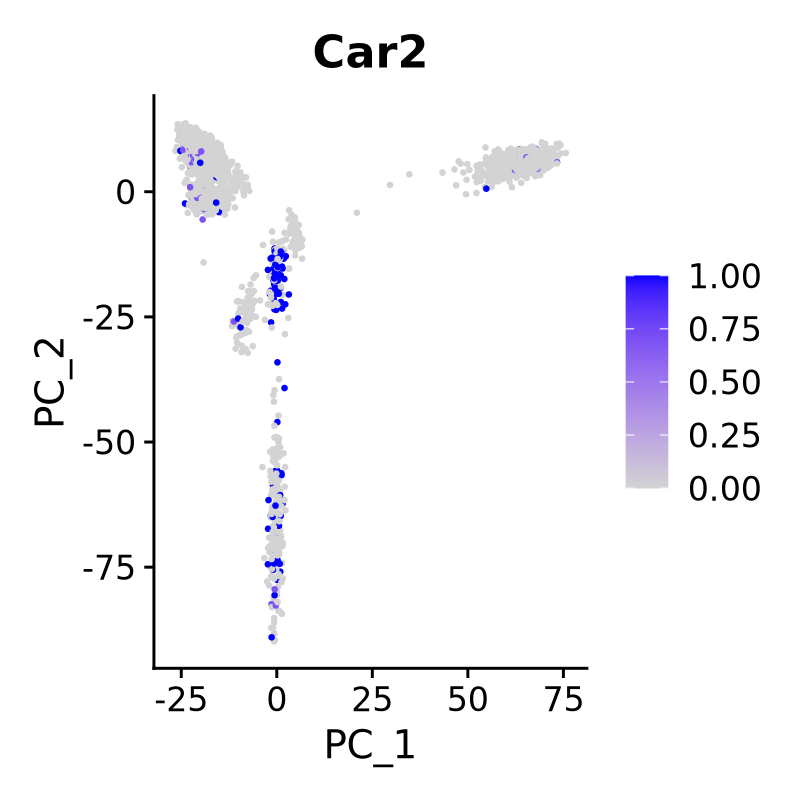

In [6]:
options(repr.plot.height=4,repr.plot.width=4,repr.plot.res=200)
FeaturePlot(charm, features = "Car2",max.cutoff = 1)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'



Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'



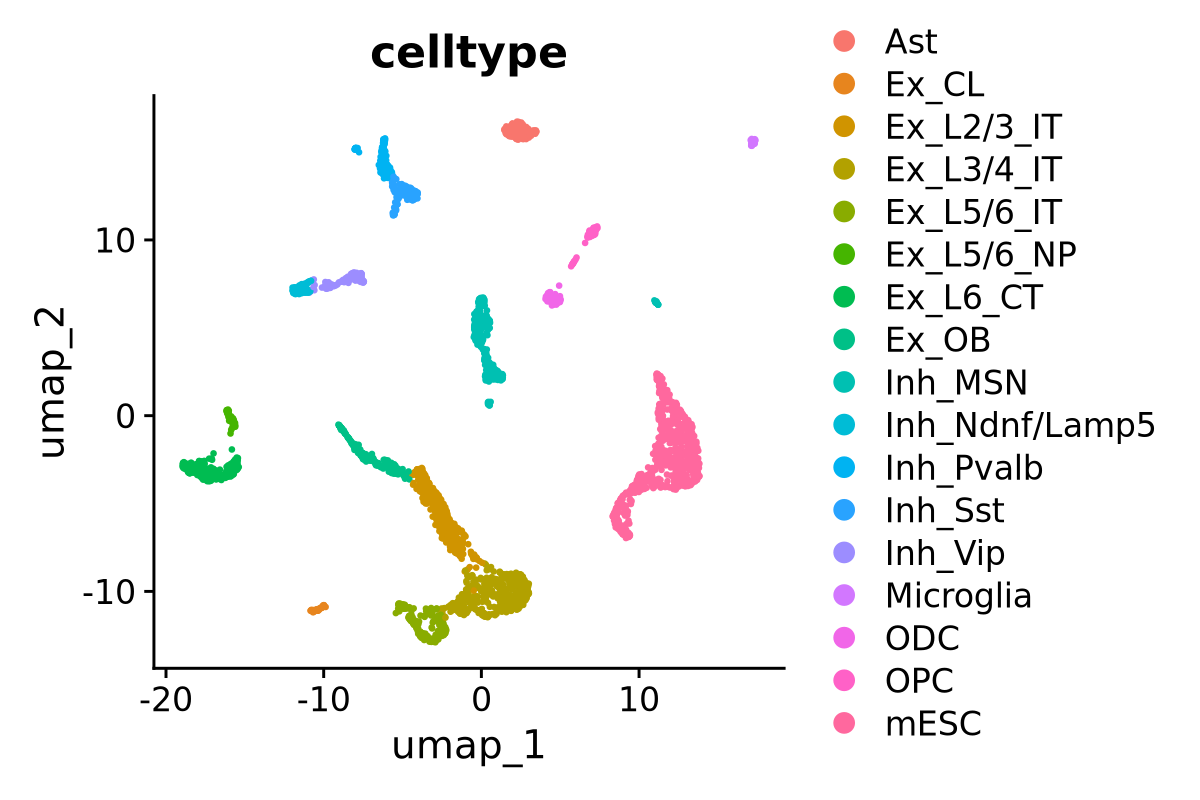

In [7]:
charm %>% RunUMAP(dims = 1:20,verbose = FALSE) -> charm
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=200)
DimPlot(charm,group.by="celltype",reduction="umap") 

In [8]:
Idents(charm) <- "celltype"
markers = FindMarkers(charm,ident.1="mESC",only.pos=TRUE)

In [9]:
markers %>% filter(p_val_adj < 0.01) %>% rownames_to_column("gene") %>% write_tsv("mesc_markers.txt")

In [10]:
variable_genes = VariableFeatures(charm)

In [11]:
variable_genes %>% as.data.frame() %>% write_tsv("all.top5k.variablegenes.tsv",col_names = FALSE)

In [12]:
charm[["RNA"]]$counts %>% as.matrix() %>% as.data.frame() %>% rownames_to_column("gene") %>% write_tsv("all.rna.tsv.gz")

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.2 GiB"


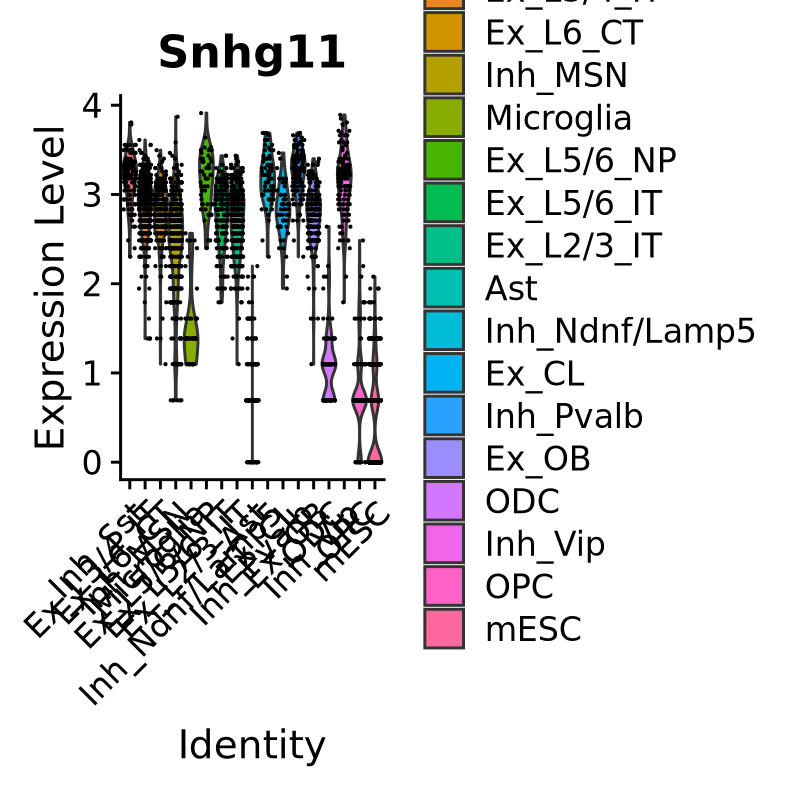

In [39]:
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res=200)
VlnPlot(charm,features="Snhg11")

In [14]:
charm[[]] %>% select(cellname, celltype) %>% write_tsv("all.metadata.tsv",col_names = FALSE)

In [15]:
charm %>% FindNeighbors(dims = 1:20) %>% FindClusters(resolution = 15) -> charm
charm %>% FindNeighbors(dims = 1:20) %>% FindClusters(resolution = 20) -> charm
charm %>% FindNeighbors(dims = 1:20) %>% FindClusters(resolution = 25) -> charm


Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3456
Number of edges: 98941

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5682
Number of communities: 72
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3456
Number of edges: 98941

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4992
Number of communities: 93
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3456
Number of edges: 98941

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4399
Number of communities: 105
Elapsed time: 0 seconds


In [16]:
charm[[]] %>% select(cellname,celltype,SCT_snn_res.15,SCT_snn_res.20,SCT_snn_res.25)%>% write_tsv("all.metadata.tsv",col_names = FALSE)

In [17]:
charm[["SCT"]]$data %>% as.matrix() %>% t() %>% as.data.frame() %>% rownames_to_column("cellname") %>% 
    left_join(charm[[]] %>% select(cellname, SCT_snn_res.15)) %>% select(-cellname) %>% group_by(SCT_snn_res.15) %>% 
    summarise_all(mean) -> mc_rna_mat
mc_rna_mat %>% write_tsv("SCT_metacellmean.tsv.gz")

Joining with `by = join_by(cellname)`


In [18]:
Idents(charm) <- "celltype"
markers = FindMarkers(charm,ident.1 = c("Ex_L2/3_IT","Ex_L3/4_IT","Ex_L5/6_IT","Ex_L5/6_NP","Ex_L6_CT","Ex_CL"),
                  ident.2 = c("Inh_Pvalb","Inh_Sst","Inh_MSN","Inh_Vip","Inh_Ndnf/Lamp5"))

In [19]:
markers

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Satb2,3.563160e-306,5.3545135,0.966,0.117,1.130698e-301
Ptprd,3.818181e-304,2.4660133,1.000,0.982,1.211623e-299
Nav3,1.412543e-289,1.9128038,1.000,0.971,4.482424e-285
Arpp21,4.486655e-278,2.2971802,0.999,0.696,1.423750e-273
Rbms3,4.458727e-275,-3.4773152,0.511,0.980,1.414888e-270
Gad2,5.361313e-272,-6.4547450,0.028,0.756,1.701306e-267
Dlx6os1,3.376253e-270,-7.7780785,0.014,0.733,1.071386e-265
Kalrn,3.556009e-251,1.2874126,0.999,0.994,1.128428e-246
Dpp6,7.278194e-247,-2.0494059,0.870,1.000,2.309589e-242
